#In this notebook, we will approach to address the tasks given using data visualisation and the Seasonal ARIMA model.

By: Sibikrishnan A.G.

## Libraries used:
- `pandas`: Efficient data handling.
- `matplotlib`: For data visualization.
- `ARIMA`: To model time series and forecast prices.
- `interp1d`: For estimating prices on arbitrary dates using interpolation.
- `auto_arima`: Automates parameter selection for ARIMA models, saving time.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.arima.model import ARIMA
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#DOWNLOAD AND IMPORT PMDARIMA FOR AUTO ARIMA
!pip install pmdarima
from pmdarima import auto_arima

# Data Preprocessing

In [ ]:
#LOAD AND PREPROCESS DATA

file_path = './Nat_Gas.csv'
data = pd.read_csv(file_path)


In [ ]:
#Brief look at the data structure
data.head()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [ ]:
data.describe()


,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [ ]:
#Convert 'Dates' to datetime format and set index
data['Dates'] = pd.to_datetime(data['Dates']) + MonthEnd(0)
data.set_index('Dates', inplace=True)

<ipython-input-21-de7920bbe36a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Dates'] = pd.to_datetime(data['Dates']) + MonthEnd(0)


- Ensure 'Dates' are in a standard datetime format and aligned to month-end, as the data represents monthly snapshots.
- Set 'Dates' as the index to make it easier to perform time series operations like forecasting and visualization.

# Initial Visualisaiton  
- We visualise the above data to understand any underlying trends, seasonality or irregularities.
- These initial plots provide insights into whether prices are stationary, which informs the ARIMA model selection.

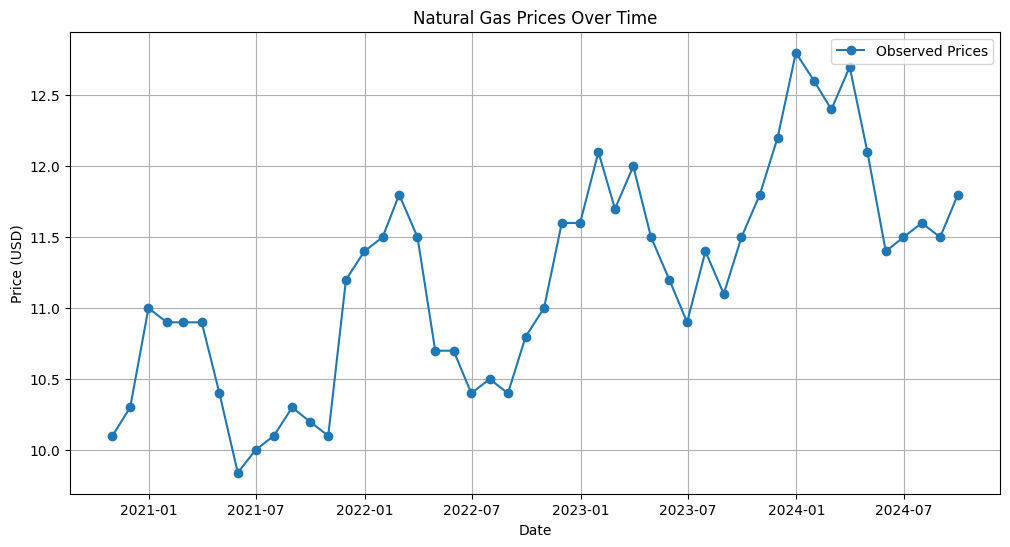

In [ ]:
#VISUALISE OBSERVED DATA

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Prices'], marker='o', label='Observed Prices')
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.legend()
plt.show()


# Seasonal Decomposition

## Decomposing the time series helps us to break the data into trend, seasonality and residuals, offering deeper insights into components influencing price movements.

## In the seasonal chart, we can see the price of oil goes through cycles, suggesting that a standard ARIMA model is not best to be applied here, rather, we can use a Seasonal ARIMA(SARIMA) model.

## We can further confirm the seasonal nature of the dataset using the ADF test below.


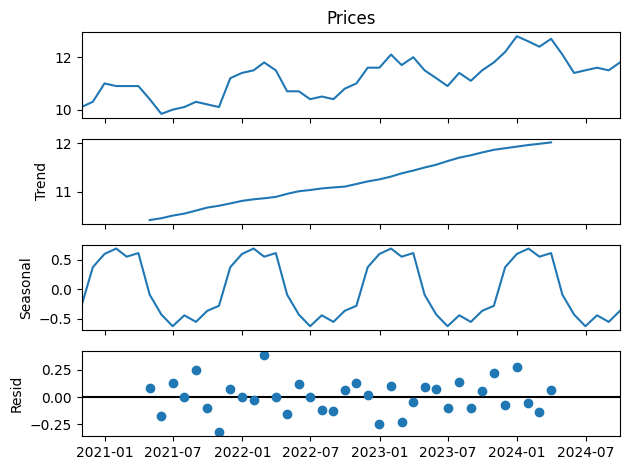

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(data['Prices'], model='additive', period=12)

# Plot decomposition
decomposition.plot()
plt.show()


# Stationarity Check

In [ ]:
# Function to check stationarity
def check_stationarity(timeseries):
    adf_test = adfuller(timeseries.dropna())
    p_value = adf_test[1]

    print("ADF Statistic:", adf_test[0])
    print("p-value:", p_value)

    if p_value < 0.05:
        print("The data is stationary (reject null hypothesis).")
        return True
    else:
        print("The data is not stationary (fail to reject null hypothesis).")
        return False

# Check if the original data is stationary
print("Checking stationarity of the original data:")
is_stationary = check_stationarity(data['Prices'])


Checking stationarity of the original data:
ADF Statistic: 0.21807686169999427
p-value: 0.973257438844869
The data is not stationary (fail to reject null hypothesis).


- We use the ADF test to see if the original dataset has stationarity, to see if ARIMA model would be suitable for it.
- As we can see, the p-value is more than 0.05, suggesting the data is not stationary, and with a high p-value of 0.973, it indicates that there is a high likelihood of seasonality present in this data.
- Therefore, a Seasonal ARIMA(SARIMA) model would be more fitting.

### SARIMA models require us to select 7 parameters: \(p, d, q\) for the non-seasonal component, and \(P, D, Q, s\) for the seasonal component.

- Manually choosing the best combination of these parameters can be challenging, especially for datasets with strong seasonal patterns.
- We can use `auto_arima` to automate this process by testing various combinations of both non-seasonal and seasonal parameters and selecting the optimal configuration based on statistical metrics like AIC (Akaike Information Criterion).
- This automation saves time and ensures the model is tuned effectively for both trends and seasonality in the data.

In [ ]:
# Determine seasonal parameters with auto_arima
sarima_model = auto_arima(
    data['Prices'],
    seasonal=True,        # Enable seasonal ARIMA
    m=12,                 # Seasonal period (12 months)
    trace=True,           # Display fitting process
    suppress_warnings=True,
    stepwise=True         # Stepwise search for parameters
)

print(f"Selected SARIMA order: {sarima_model.order} Seasonal order: {sarima_model.seasonal_order}")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=37.147, Time=2.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.09 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=39.069, Time=9.46 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.330, Time=6.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=36.109, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953, Ti

# Adjusted for SARIMA Context

## As we now have both the ARIMA and seasonal parameters (`order` and `seasonal_order`) from the `auto_model` object's attributes, we can use them as the selected orders and fit the SARIMA model to the data.
- **Fitting the SARIMA model** allows us to capture both the **seasonal patterns** and the **trends** in the data, making it more suitable for datasets with recurring fluctuations like natural gas prices.
- Therefore, we generate a **forecast for the next 12 months** while accounting for seasonality and trends.
- The **confidence intervals** provide insights into the uncertainty of the forecasts, offering a range for the expected values. This is especially valuable in decision-making scenarios where understanding prediction reliability is critical.

This explanation highlights SARIMA's ability to handle seasonality, enhancing its relevance to the dataset at hand.

In [ ]:
#Fit the SARIMA model
sarima = SARIMAX(data['Prices'],
                 order=sarima_model.order,
                 seasonal_order=sarima_model.seasonal_order)
sarima_result = sarima.fit()


print(sarima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Prices   No. Observations:                   48
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -12.902
Date:                Fri, 22 Nov 2024   AIC                             35.804
Time:                        01:53:18   BIC                             45.055
Sample:                    10-31-2020   HQIC                            39.285
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7071      0.054     31.614      0.000       1.601       1.813
ar.L2         -0.9694      0.052    -18.494      0.000      -1.072      -0.867
ma.L1         -1.8219      1.912     -0.953      0.3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


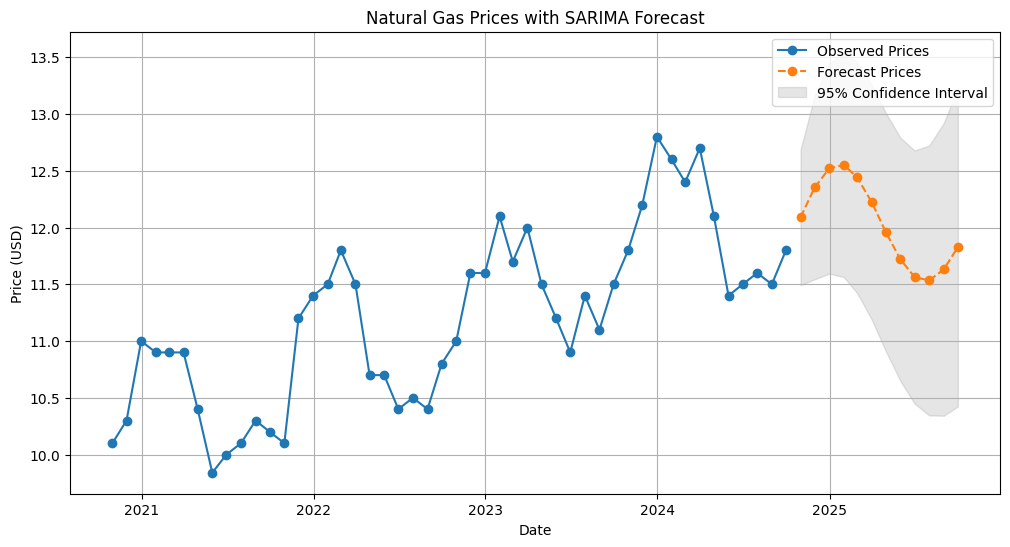

In [ ]:
# Plot observed and forecasted data with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Prices'], marker='o', label='Observed Prices')
plt.plot(forecast_series.index, forecast_series, linestyle='--', marker='o', label='Forecast Prices')
plt.fill_between(forecast_series.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Natural Gas Prices with SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.legend()
plt.show()


- Combining observed and forecasted data helps visualise how well the model aligns with historical patterns.
- Confidence intervals convey the range of uncertainty, making predictions more interpretable.

In [ ]:
# Split data into training and test sets
train_data = data['Prices'][:-12]
test_data = data['Prices'][-12:]

# Fit SARIMA on training data
sarima_train = SARIMAX(train_data,
                       order=sarima_model.order,
                       seasonal_order=sarima_model.seasonal_order)
sarima_train_result = sarima_train.fit()

# Predict on test data
validation_forecast = sarima_train_result.get_forecast(steps=12).predicted_mean

# Compute validation metrics
mse = mean_squared_error(test_data, validation_forecast)
mae = mean_absolute_error(test_data, validation_forecast)
rmse = mean_squared_error(test_data, validation_forecast, squared=False)

print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
print(f"Validation Mean Absolute Error (MAE): {mae:.4f}")
print(f"Validation Root Mean Squared Error (RMSE): {rmse:.4f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Validation Mean Squared Error (MSE): 0.5475
Validation Mean Absolute Error (MAE): 0.5650
Validation Root Mean Squared Error (RMSE): 0.7400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Forecast for the next 12 months
forecast_obj = sarima_result.get_forecast(steps=12)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()
forecast_dates = [data.index[-1] + MonthEnd(i) for i in range(1, 13)]
forecast_series = pd.Series(forecast.values, index=forecast_dates)

# Validation ensures the model's predictions are accurate by comparing them against a test set. Metrics like MSE, MAE, and RMSE quantify this accuracy.

### SARIMA Model Validation Results
Validation ensures the model's predictions are accurate by comparing them against a test set. Metrics like MSE, MAE, and RMSE quantify this accuracy.

- **Validation Mean Squared Error (MSE)**: **0.5475**
- **Validation Mean Absolute Error (MAE)**: **0.5650**
- **Validation Root Mean Squared Error (RMSE)**: **0.7400**

---

### **1. Mean Squared Error (MSE)**
- **Definition**: The average of the squared differences between predicted and actual values.
- **Value**: **0.5475** indicates that, on average, the square of the prediction error is around **0.5475**.
- **Interpretation**:
  - Smaller MSE values indicate better model performance, as it penalizes larger errors more heavily than smaller ones.
  - Since SARIMA incorporates seasonality, this result suggests the model successfully captures recurring seasonal patterns, minimizing large prediction errors.

---

### **2. Mean Absolute Error (MAE)**
- **Definition**: The average of the absolute differences between predicted and actual values.
- **Value**: **0.5650** suggests that, on average, the SARIMA model's predictions deviate from the actual values by approximately **0.5650 units of price**.
- **Interpretation**:
  - MAE being close to the MSE value indicates relatively uniform errors, suggesting the SARIMA model is consistently accurate.
  - Since MAE is less sensitive to outliers, this value reinforces that the SARIMA model has no extreme prediction errors.

---

### **3. Root Mean Squared Error (RMSE)**
- **Definition**: The square root of the MSE, providing the error in the same units as the data.
- **Value**: **0.7400** indicates that the typical prediction error is approximately **0.74 units of price**.
- **Interpretation**:
  - RMSE combines the advantages of MSE (penalizing large errors) and MAE (being in the same units as the data), offering a well-rounded measure of model performance.
  - RMSE being slightly higher than MAE suggests that the model occasionally makes larger errors, but they are not significant enough to compromise overall accuracy.

---

### **Key Takeaways**
1. **Overall Model Performance**:
   - The low MSE, MAE, and RMSE values suggest that the SARIMA model performs well on the test data.
   - The results indicate that the SARIMA model captures both seasonal and non-seasonal patterns effectively.

2. **Comparison to Data Range**:
   - If the price data ranges between **0 and 13**, an RMSE of **0.74** suggests that the model has a small prediction error relative to the overall scale of the data.

3. **Improvement Areas**:
   - If these errors are still too high for your use case, consider:
     - Adding external variables (e.g., economic indicators, weather patterns) to improve the model's explanatory power.
     - Using advanced models like SARIMAX (SARIMA with exogenous variables) or machine learning-based forecasting techniques.

---

### **Conclusion**
The SARIMA model demonstrates strong predictive accuracy, leveraging seasonal and non-seasonal components effectively. Its validation metrics indicate reliable performance, making it a robust choice for forecasting natural gas prices in this context.

## This function integrates past data (using interpolation) and future forecasts to estimate prices for arbitrary dates.

In [ ]:
#Interpolation function for past dates
ordinal_dates = data.index.map(pd.Timestamp.toordinal)
interpolation_func = interp1d(
    ordinal_dates, data['Prices'], kind='linear', fill_value="extrapolate"
)


#Define 'all_data' (observed + forecasted)
# all_data = pd.concat([data['Prices'], forecast_series])

def estimate_price(input_date):
    """
    Estimate the natural gas price for a given date.
    :param input_date: str, date in the format 'YYYY-MM-DD'
    :return: float, estimated price or message if date is invalid
    """
    input_date = pd.to_datetime(input_date) + MonthEnd(0)
    input_ordinal = input_date.toordinal()

    if input_date in all_data.index:
        return all_data.loc[input_date]
    elif input_ordinal <= ordinal_dates[-1]:
        # Use interpolation for past dates
        return interpolation_func(input_ordinal)
    elif input_date in forecast_series.index:
        # Use forecast for future dates
        return forecast_series[input_date]
    else:
        return "Date outside the available range"


## The above cell allows users to interact with the notebook by providing a date to estimate prices.

The exception handling ensures that the program doesn't crash or hang from invalid user input.

In [ ]:
#Prompt the user for a date
input_date = input("Enter a date (YYYY-MM-DD) to estimate the price: ")

#Estimate the price for the given date
try:
    estimated_price = estimate_price(input_date)
    if isinstance(estimated_price, float):
        print(f"The estimated price on {input_date} is: {estimated_price:.2f} USD")
    else:
        print(estimated_price)
except Exception as e:
    print(f"Error: {e}")


Enter a date (YYYY-MM-DD) to estimate the price: 2025-03-26
The estimated price on 2025-03-26 is: 12.22 USD
